# 94-867 Decision Analytics for Business and Policy 
## Team 12: Abigail Zhang, Enze Zhao, Jingchen Fu, Mandi Liu
## Final Project: Maximizing Bank Profit Success: An Optimized Marketing Strategy
## Optimization Model

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

from scipy.optimize import linprog

from gurobipy import Model, GRB, quicksum

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report

In [2]:
# Load the dataset
bank_data_cleaned = pd.read_csv('data/df_cleaned.csv')

bank_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          45211 non-null  object
 2   marital      45211 non-null  object
 3   education    45211 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   day_of_week  45211 non-null  int64 
 9   month        45211 non-null  object
 10  duration     45211 non-null  int64 
 11  campaign     45211 non-null  int64 
 12  pdays        45211 non-null  int64 
 13  previous     45211 non-null  int64 
 14  y            45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [3]:
# Feature Sensitivity Analysis: Focus on 'age', 'balance', and 'education'
# For simplicity, we'll convert 'education' to numerical values for analysis
education_mapping = {'primary': 1, 'secondary': 2, 'tertiary': 3}
bank_data_cleaned['education_numeric'] = bank_data_cleaned['education'].map(education_mapping)

df = bank_data_cleaned
df.head()


,age,job,marital,education,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,previous,y,education_numeric
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no,3
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no,2
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no,2
3,47,blue-collar,married,secondary,no,1506,yes,no,5,may,92,1,-1,0,no,2
4,33,blue-collar,single,secondary,no,1,no,no,5,may,198,1,-1,0,no,2


In [4]:
# Assuming df is our cleaned dataframe with a 'y' column indicating if the client subscribed

# Convert categorical variables to numeric encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    if column != 'y':  # We don't want to transform the target variable
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Split the data into features and target
X = df.drop(columns=['y', 'education'], axis=1)
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

predictions = model.predict(X_test_scaled)

# Predict probabilities for the training set
probabilities = model.predict_proba(X_train_scaled)[:, 1]  # get the probability of class 1

# Add the probabilities back to the dataframe
df_train = X_train.copy()
df_train['P_i'] = probabilities

# Now df_train has a new column 'P_i' which is the predicted probability of subscription

recall from our objective function equation which is maximize net profit= sum of (profit per subscription * probability of subscription * Xi) = sum(cost of call * Xi), where we use this logistic regression model to make test set predicition and calculate the positive class probabilities for the training set. Then we used these probabilities as the predicted probability of subscription back into our equation. 

In [5]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8658
           1       0.21      0.58      0.30       385

    accuracy                           0.89      9043
   macro avg       0.59      0.74      0.62      9043
weighted avg       0.95      0.89      0.91      9043



by looking at the classification report, class 0 (the 'no' class), the precision is 0.98, indicating that the model is very good at predicting the non-subscribers.

In [6]:
print(confusion_matrix(predictions, y_test))

[[7792  866]
 [ 160  225]]


In [7]:
coefficients = model.coef_[0]
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print(coef_df)

              Feature  Coefficient
9            duration     1.004048
11              pdays     0.299484
13  education_numeric     0.191544
12           previous     0.191510
2             marital     0.128698
0                 age     0.077635
4             balance     0.049826
1                 job     0.047818
8               month    -0.002621
7         day_of_week    -0.020720
3             default    -0.052342
6                loan    -0.235232
10           campaign    -0.410217
5             housing    -0.573354


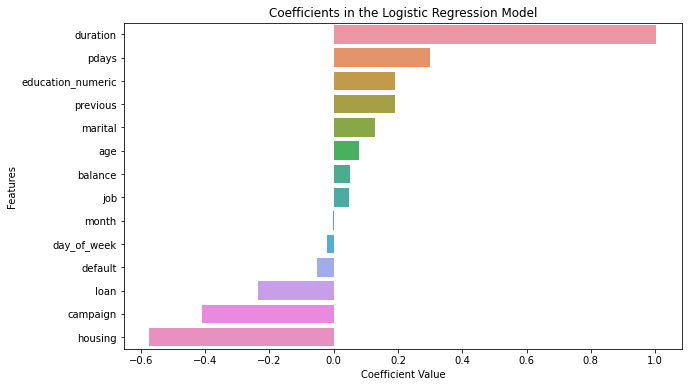

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Coefficients in the Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

Based on the result of the logistic regression it helps us to do feature selection, we should drop the features that do not have large impact on the dependant variables.

So we decided to drop: balance, job, month, day_of_week, default

In [9]:
drop_columns = ['balance', 'job', 'month', 'day_of_week', 'default']
df_train = df_train.drop(columns=drop_columns, axis=1)
df_train.head()

,age,marital,housing,loan,duration,campaign,pdays,previous,education_numeric,P_i
3344,41,1,1,0,72,1,-1,0,1,0.016512
17965,49,1,1,0,269,2,-1,0,1,0.035664
18299,42,1,0,0,130,4,-1,0,2,0.057246
10221,37,2,1,0,375,11,-1,0,3,0.032112
32192,56,1,0,0,264,2,-1,0,1,0.104000


In [10]:

number_of_rows = len(df_train.index)
print(f"The DataFrame has {number_of_rows} rows.")

The DataFrame has 36168 rows.


In [11]:
df_train.to_csv('data/before_dummy.csv', index=False)

In [12]:
edu_df = pd.get_dummies(df_train['education_numeric'], prefix='is')
df_train = pd.concat([df_train, edu_df], axis=1)

In [13]:
df_train = df_train.rename(columns={'is_1': 'is_primary', 'is_2': 'is_secondary', 'is_3': 'is_tertiary'})
df_train.head()

,age,marital,housing,loan,duration,campaign,pdays,previous,education_numeric,P_i,is_primary,is_secondary,is_tertiary
3344,41,1,1,0,72,1,-1,0,1,0.016512,1,0,0
17965,49,1,1,0,269,2,-1,0,1,0.035664,1,0,0
18299,42,1,0,0,130,4,-1,0,2,0.057246,0,1,0
10221,37,2,1,0,375,11,-1,0,3,0.032112,0,0,1
32192,56,1,0,0,264,2,-1,0,1,0.104000,1,0,0


In [14]:
df_train.to_csv('data/df_train.csv', index=False)

### We decided to use the dataset called before_dummy dataset to optimze the first two model, and df_train csv file to optimze the last model. 

In [15]:


# Load your dataset
df = pd.read_csv('data/before_dummy.csv')

# Initialize the Gurobi model
m = Model("marketing_campaign_optimization_1")

# Add variables to the model
# x[i] is a binary variable that indicates whether to target client i (1) or not (0)
x = m.addVars(df.index, vtype=GRB.BINARY, name="x")

# Objective function constants
profit_per_subscription = 10
cost_per_call = 2


# Set objective
m.setObjective(
    quicksum(profit_per_subscription * df['P_i'][i] * x[i] for i in df.index) - quicksum(cost_per_call * x[i] for i in df.index), GRB.MAXIMIZE)

# Constraints
# Maximum number of calls (M)
max_calls = 1000
# Maximum total call duration (D)
max_duration = 10000

# Add constraint for the maximum number of calls
m.addConstr(quicksum(x[i] for i in df.index) <= max_calls, "max_calls")

# Add constraint for the maximum total call duration
m.addConstr(quicksum(df.loc[i, 'duration'] * x[i] for i in df.index) <= max_duration, "max_duration")



# Optimize the model
m.optimize()

if m.status == GRB.OPTIMAL:
    print(f'Optimal value (maximized profit): {m.objVal}')
    num_calls_needed = sum(v.x >= 0.5 for v in m.getVars())
    print(f'Number of clients selected: {num_calls_needed}')
    total_expected_subscriptions = sum(df.loc[i, 'P_i'] * x[i].x for i in df.index)
    print(f'Total expected subscriptions: {total_expected_subscriptions}')
else:
    print("Optimization was not successful.")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2 rows, 36168 columns and 72334 nonzeros
Model fingerprint: 0x16265c5d
Variable types: 0 continuous, 36168 integer (36168 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+04]
Found heuristic solution: objective 49.4364031
Presolve removed 1 rows and 30724 columns
Presolve time: 0.10s
Presolved: 1 rows, 5444 columns, 5444 nonzeros
Variable types: 0 continuous, 5444 integer (5444 binary)
Found heuristic solution: objective 74.0988464

Root relaxation: objective 2.100599e+02, 1 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds

In [16]:
# Load your dataset
df = pd.read_csv('data/before_dummy.csv')

# Initialize the Gurobi model
m = Model("marketing_campaign_optimization")

# Add variables to the model
# x[i] is a binary variable that indicates whether to target client i (1) or not (0)
x = m.addVars(df.index, vtype=GRB.BINARY, name="x")


# Objective function constants
profit_per_subscription = 10
cost_per_call = 2

# Set objective
m.setObjective(
    quicksum(profit_per_subscription * df['P_i'][i] * x[i] for i in df.index) - quicksum(cost_per_call * x[i] for i in df.index), GRB.MAXIMIZE)
# Add constraint for the minimum expected subscriptions
min_subscriptions = 1000
m.addConstr(quicksum(df.loc[i, 'P_i'] * x[i] for i in df.index) >= min_subscriptions, "min_subscriptions")

# Optimize the model
m.optimize()

# Output the results
if m.status == GRB.OPTIMAL:
    print(f'Optimal value (maximized profit): {m.objVal}')
    num_calls_needed = sum(v.x >= 0.5 for v in m.getVars())
    print(f'Number of clients selected: {num_calls_needed}')
    total_expected_subscriptions = sum(df.loc[i, 'P_i'] * x[i].x for i in df.index)
    print(f'Total expected subscriptions: {total_expected_subscriptions}')
else:
    print("Optimization was not successful.")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1 rows, 36168 columns and 36168 nonzeros
Model fingerprint: 0x7c02e772
Variable types: 0 continuous, 36168 integer (36168 binary)
Coefficient statistics:
  Matrix range     [9e-06, 1e+00]
  Objective range  [3e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+03]
Found heuristic solution: objective 11579.100132

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: 11579.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.157910013178e+04, best bound 1.157910013178e+04, gap 0.0000%
Optimal value (maximized profit): 11579.100131775594
Number of clients selected: 5444
Total expected subscriptions: 2246.7100131775583


the reason why our team decided to use the csv file called before dummy because the first two models have no constraints on edicational level. The df_train csv file contains dummy values for clients who are either primary, secondary and tertiary edicational level. Our team created three new columns called is_primary, is_secondary, and is_tertiary with dummy values. Therefore, the df_train csv file is used for model 3 only because we created a constraint for minimum number of primary educated clients is 1000. 

In [18]:

df = pd.read_csv('data/df_train.csv')
# Initialize the Gurobi model
m = Model("marketing_campaign_optimization")

# Create a new binary column for clients with primary education
df['is_primary'] = df['education_numeric'].apply(lambda x: 1 if x == 1 else 0)

# Add variables to the model
# x[i] is a binary variable that indicates whether to target client i (1) or not (0)
x = m.addVars(df.index, vtype=GRB.BINARY, name="x")

# Objective function weights and constants
profit_per_subscription = 10
cost_per_call = 2

# Set objective
m.setObjective(
    quicksum(profit_per_subscription * df['P_i'][i] * x[i] for i in df.index) - quicksum(cost_per_call * x[i] for i in df.index), GRB.MAXIMIZE)

# Add constraint for the minimum number of primary educated clients
min_primary = 1000
m.addConstr(quicksum(df.loc[i, 'is_primary'] * x[i] for i in df.index) >= min_primary, "min_primary")

# Optimize the model
m.optimize()

# Output the results
if m.status == GRB.OPTIMAL:
    print(f'Optimal value (maximized profit): {m.objVal}')
    num_calls_needed = sum(v.x >= 0.5 for v in m.getVars())
    print(f'Number of clients selected: {num_calls_needed}')
    total_expected_subscriptions = sum(df.loc[i, 'P_i'] * x[i].x for i in df.index)
    print(f'Total expected subscriptions: {total_expected_subscriptions}')
else:
    print("Optimization was not successful.")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1 rows, 36168 columns and 5476 nonzeros
Model fingerprint: 0xabd5096b
Variable types: 0 continuous, 36168 integer (36168 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+03]
Found heuristic solution: objective 10846.450549
Presolve removed 0 rows and 31202 columns
Presolve time: 0.07s
Presolved: 1 rows, 4966 columns, 4966 nonzeros
Variable types: 0 continuous, 4966 integer (4966 binary)
Found heuristic solution: objective 10896.711082

Root relaxation: objective 1.132779e+04, 1 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node